In [1]:
# Tabular data manipulation
import pandas as pd
import numpy as np

# Data manipulation
import re

# Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics import tsaplots #ACF PACF

# Type-hinting
from typing import NewType, List, Tuple, Union
from dataenforce import Dataset

# Plotting
import matplotlib.pyplot as plt

# FP
import pdpipe as pdp
from functools import reduce

# Tests
#import arch

In [3]:
import datetime as dt
import pandas_datareader.data as web
st = dt.datetime(1990,1,1)
en = dt.datetime(2020,1,1)
data = web.get_data_yahoo('AAPL', start=st, end=en)
data
returns = data['Adj Close'].pct_change().dropna()

In [4]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
hist = msft.history(period="20y")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-10-12,17.614477,17.911741,17.250802,17.829519,63307000,0.0,0.0
2001-10-15,17.677727,18.499946,17.661914,18.360802,68437000,0.0,0.0
2001-10-16,18.300708,18.629596,18.091991,18.484127,66169000,0.0,0.0
2001-10-17,18.696004,18.752927,17.703017,17.718828,73710600,0.0,0.0
2001-10-18,17.816868,18.209004,17.551228,17.946526,78348000,0.0,0.0


In [5]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,0.334821,0.312500,0.314732,0.332589,183198400.0,0.266812
1990-01-03,0.339286,0.334821,0.339286,0.334821,207995200.0,0.268603
1990-01-04,0.345982,0.332589,0.341518,0.335938,221513600.0,0.269499
1990-01-05,0.341518,0.330357,0.337054,0.337054,123312000.0,0.270394
1990-01-08,0.339286,0.330357,0.334821,0.339286,101572800.0,0.272185


<AxesSubplot:xlabel='Date'>

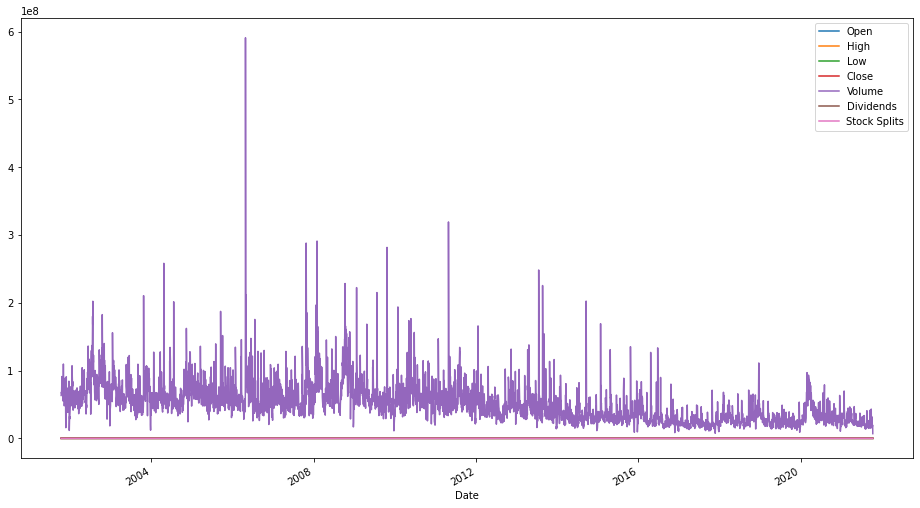

In [6]:
import matplotlib.pyplot as plt
import seaborn

# Plot everything by leveraging the very powerful matplotlib package
hist.plot(figsize=(16, 9))

# Data Import

In [7]:
pd_timestamp = NewType('pd_timestamp', pd._libs.tslibs.timestamps.Timestamp)

In [8]:
sheets=['PE (TTM) Ratios', 'Equity Price Indices']
indexes=['S&P 500', 'FTSE 100', 'Bovespa', 'Hang Seng']

In [9]:
# Importing Indexes

def import_index_and_pe_data(excel_filepath: str, sheets: List[str]) -> Tuple[Dataset, Dataset]:
    """
    Params:
    -----------
    excel_filepath: str
      A filepath specifying the filepath to Excel
      
    sheets: List[str]
      A list of sheets names
      
    Returns:
    -----------
    
    """
    data = pd.read_excel(excel_filepath, sheet_name=None, skiprows=2)
    num_sheets=len(sheets)
    
    eval_expression = ", ".join(f'data[\'{sheet}\'][::-1].reset_index(drop=True)' for sheet in sheets)
    
    return eval(eval_expression)


In [10]:
index, pe_ratio = import_index_and_pe_data(
    excel_filepath='Global_Equity_Valuations_Researcher_Dataset.xlsx',
    sheets=['Equity Price Indices', 'PE (TTM) Ratios'])

FileNotFoundError: [Errno 2] No such file or directory: 'Global_Equity_Valuations_Researcher_Dataset.xlsx'

# Data Transformation

In [8]:
pipeline = pdp.PdPipeline([pdp.ColRename({'Calculated Using:': 'Date'}), pdp.RowDrop({'Date': lambda row: row < pd.Timestamp('1999-12-31')})])

index_data, pe_ratio_data = [pipeline(df).reset_index(drop=True) for df in [index, pe_ratio]]

NameError: name 'index' is not defined

In [ ]:
def return_column_names(list_of_indexes: List[str], column_names: List[str]) -> List[str]:
    
    cols = []
    
    for index in indexes:
        for col in column_names:
            if index in col:
                cols.append(col)
                
    cols.insert(0, 'Date')
            
    return cols

In [ ]:
cols = return_column_names(indexes, index_data.columns.to_list())

In [ ]:
index_sub = index_data.loc[:, cols]
pe_sub = pe_ratio_data.loc[:, cols]

In [ ]:
rename_dict = {'S&P 500 Index': 'S&P500', 'FTSE 100 Index': 'FTSE100', 'Bovespa Index (Ibovespa)': 'Bovespa', 'Hang Seng Index': 'HangSeng'}

index_filtered, pe_filtered = [pdp.ColRename(rename_dict).apply(df) for df in [index_sub, pe_sub]]

In [ ]:
select_columns=['S&P500', 'FTSE100', 'Bovespa', 'HangSeng']

In [ ]:
# def create_earnings_yield_data(pe_ratio_df: Dataset, columns=List[str]) -> Dataset:
    
#    pipeline = pdp.PdPipeline([pdp.ApplyByCols(columns=columns, func=np.reciprocal, drop=True)])
    
#    return pipeline(pe_ratio_df)

In [ ]:
# earnings_yield_filtered = create_earnings_yield_data(pe_filtered, columns = select_columns)

In [ ]:
def shift_columns(data: Dataset, columns:List[str]) -> Dataset:
    return_data = data.copy()
    
    for column in columns:
        return_data[column] = return_data[column].shift(1)
        
    return return_data.dropna()

In [ ]:
def diff_columns(data: Dataset, columns: List[str]) -> Dataset:
    return_data = data.copy()
    
    for column in columns:
        return_data[column] = return_data[column].diff(1)
        
    return return_data.dropna()

In [ ]:
def log_data(data: Dataset, columns:List[str]) -> Dataset:
    return_data = data.copy()
    
    for column in columns:
        return_data[column] = np.log(return_data[column])
        
    return return_data.dropna()

In [ ]:
pe_shifted = shift_columns(pe_filtered, columns=select_columns)

In [ ]:
monthly_yield = diff_columns(log_data(index_filtered, columns=select_columns), select_columns)

In [ ]:
def rename_columns(dataframe: Dataset, column_tag: str, *args) -> Dataset:
    # Excluding 'Date' column
    present_colnames = dataframe.columns.to_list()[1:]
    new_colnames = [name + column_tag for name in present_colnames]
    rename_dict = dict(zip(present_colnames, new_colnames))
    new_dataframe = dataframe.rename(columns=rename_dict)
    
    return new_dataframe

In [ ]:
rename_args = [[index_filtered, '_Index'], [pe_shifted, '_PE'], [monthly_yield, '_Yield']]

In [ ]:
[index_cleared, pe_cleared, yield_cleared] = [rename_columns(*arg) for arg in rename_args]

In [ ]:
df_list = [index_cleared, pe_cleared, yield_cleared]

In [ ]:
def join_dataframes(join_dfs: list, join_type: str='inner', join_on: str='Date') -> Dataset:
    """
    Params:
    ----------------
    join_dfs: list
      List containing the dataframes to be joined
    join_type: str
      Specifies the type of join to be performed. Default is 'inner'.
    join_on: str
      Specifies the id column for the join. Default is 'Date'.
    
    Returns:
    -----------------
    joined_df: Dataset
      The joined dataframe
    """
    
    return reduce(lambda left, right: pd.merge(left, right, on=join_on, how=join_type), join_dfs)

In [ ]:
joined = join_dataframes(df_list)

In [ ]:
def return_match(string: str, pattern: str):
    if re.findall(pattern, string):
        return string

In [ ]:
def generate_market_dataframe(fundamentals_dataframe: Dataset, market_name: str):
    
    matches = [match for match in [return_match(col, market_name) for col in fundamentals_dataframe.columns.to_list()] if match != None]
    
    # Date column is always generated
    final_columns = ['Date'] + matches
    
    return_data = fundamentals_dataframe[final_columns]
    
    new_column_names = [el[-1] for el in return_data.columns.str.split("_").to_list()]
    
    rename_dict = dict(zip(return_data.columns.to_list(), new_column_names))
    
    final_dataframe = return_data.rename(columns=rename_dict)
    
    return final_dataframe
        

In [13]:
sp500, ftse100, bovespa, hangseng = [generate_market_dataframe(joined, market) for market in select_columns]

NameError: name 'select_columns' is not defined

# Regression Analysis

In [11]:
def make_regression(dataframe: Dataset, response: str, predictors: Union[str, List[str]], intercept: bool=True):

    if intercept:
        predictors_w_constant = sm.add_constant(dataframe[predictors])
        model = sm.OLS(dataframe[response], predictors_w_constant)
        results = model.fit()
        return results
    else:
        model = sm.OLS(dataframe[response], dataframe[predictors])
        results = model.fit()
        return results

In [12]:
market_data = [sp500, ftse100, bovespa, hangseng]

NameError: name 'sp500' is not defined

### Exhibit 2a

In [ ]:
[sp500_reg2a, ftse100_reg2a, bovespa_reg2a, hangseng_reg2a] = [make_regression(market, response = 'Index', predictors = 'PE') for market in market_data]

### Exhibit 2b

In [ ]:
[sp500_reg2b, ftse100_reg2b, bovespa_reg2b, hangseng_reg2b] = [make_regression(market, response = 'Yield', predictors = 'PE') for market in market_data]

### Some Plotting

In [ ]:
pe_cleared

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('bmh')

plot_data = pe_cleared.rename(columns={'S&P500_PE': 'S&P 500', 'FTSE100_PE': 'FTSE 100', 'Bovespa_PE': 'Bovespa', 'HangSeng_PE': 'Hang Seng'})
plot_data.Date = pd.to_datetime(plot_data.Date)

ax = plot_data.plot(x = 'Date', colormap='Accent', figsize=(12, 7))
ax.set_facecolor("white")
ax.set_xlabel('Date', fontsize= 14)
ax.set_ylabel('Price/Earnings-Ratio', fontsize= 14)
plt.setp(ax.get_legend().get_texts(), fontsize=13)
plt.show()

### Data Export

In [ ]:
sp500.to_csv("sp500_data.csv")

In [ ]:
bovespa.to_csv("bovespa_data.csv")

In [ ]:
hangseng.to_csv("hangseng_data.csv")

In [ ]:
ftse100.to_csv("ftse100_data.csv")

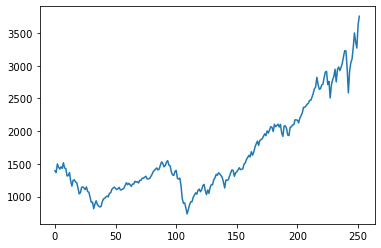

In [263]:
sp500["Index"].plot();

### Exhibit 5 & 6

In [14]:
from arch.unitroot import PhillipsPerron

In [15]:
sp500 = pd.read_csv("sp500_data.csv").iloc[:,1:5]
bovespa = pd.read_csv("bovespa_data.csv").iloc[:,1:5]
hangseng = pd.read_csv("hangseng_data.csv").iloc[:,1:5]
ftse100 = pd.read_csv("ftse100_data.csv").iloc[:,1:5]
sp500.head(1)

,Date,Index,PE,Yield
0,2000-01-31,1394.46,31.42,-0.052245


<AxesSubplot:xlabel='Yield', ylabel='PE'>

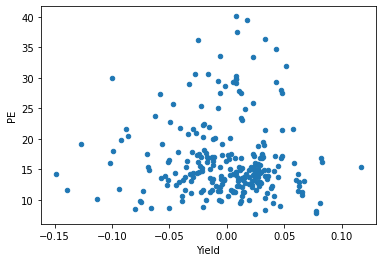

In [16]:
ftse100.plot.scatter(x = "Yield", y = "PE")

<AxesSubplot:xlabel='Yield', ylabel='PE'>

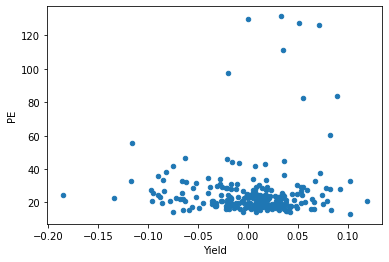

In [17]:
sp500.plot.scatter(x = "Yield", y = "PE")

In [18]:
from sklearn.linear_model import LinearRegression
X = sm.add_constant(hangseng.iloc[:,2])
reg = sm.OLS(hangseng.iloc[:,3].values, X).fit()
#reg = sm.OLS(ftse100.iloc[:,3].values, ftse100.iloc[:,2]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7938
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.374
Time:                        16:56:01   Log-Likelihood:                 351.40
No. Observations:                 252   AIC:                            -698.8
Df Residuals:                     250   BIC:                            -691.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.015      0.988      0.324      -0.015       0.044
PE            -0.0009      0.001     -0.891      0.374      -0.003       0.001
==============================================================================
Omnibus:                       20.618   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.958
Skew:                          -0.567   Prob(JB):                     8.49e-07
Kurtosis:                       4.174   Cond. No.                         56.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
sp500.iloc[:,2].values.reshape(1,-1)

array([[ 31.42,  28.95,  27.83,  29.96,  28.51,  27.71,  28.19,  27.56,
         28.9 ,  27.05,  26.62,  25.06,  25.77,  27.32,  25.58,  24.71,
         27.5 ,  29.51,  30.86,  32.92,  33.38,  33.43,  37.43,  42.04,
         44.33,  45.78,  44.82,  46.46,  43.6 ,  42.05,  37.98,  34.09,
         32.9 ,  28.17,  29.49,  32.04,  30.97,  31.01,  29.51,  28.84,
         30.24,  30.37,  29.41,  28.75,  28.08,  26.75,  27.23,  25.22,
         24.52,  23.21,  22.98,  22.12,  21.29,  20.99,  20.83,  19.62,
         19.48,  19.48,  19.56,  20.23,  20.79,  20.18,  20.36,  19.79,
         19.21,  19.46,  19.14,  19.51,  18.97,  18.79,  18.16,  18.49,
         18.17,  18.33,  18.09,  18.05,  18.04,  17.33,  17.19,  17.14,
         17.19,  17.3 ,  17.54,  17.61,  17.61,  17.64,  17.14,  17.2 ,
         17.83,  18.28,  17.83,  17.14,  17.8 ,  18.92,  19.71,  19.89,
         20.88,  20.83,  20.71,  21.22,  22.94,  24.4 ,  23.54,  24.67,
         25.88,  24.42,  21.08,  25.18,  35.79,  55.5 ,  60.22, 

In [20]:
sp500.iloc[:,2].values.reshape(1, -1)

array([[ 31.42,  28.95,  27.83,  29.96,  28.51,  27.71,  28.19,  27.56,
         28.9 ,  27.05,  26.62,  25.06,  25.77,  27.32,  25.58,  24.71,
         27.5 ,  29.51,  30.86,  32.92,  33.38,  33.43,  37.43,  42.04,
         44.33,  45.78,  44.82,  46.46,  43.6 ,  42.05,  37.98,  34.09,
         32.9 ,  28.17,  29.49,  32.04,  30.97,  31.01,  29.51,  28.84,
         30.24,  30.37,  29.41,  28.75,  28.08,  26.75,  27.23,  25.22,
         24.52,  23.21,  22.98,  22.12,  21.29,  20.99,  20.83,  19.62,
         19.48,  19.48,  19.56,  20.23,  20.79,  20.18,  20.36,  19.79,
         19.21,  19.46,  19.14,  19.51,  18.97,  18.79,  18.16,  18.49,
         18.17,  18.33,  18.09,  18.05,  18.04,  17.33,  17.19,  17.14,
         17.19,  17.3 ,  17.54,  17.61,  17.61,  17.64,  17.14,  17.2 ,
         17.83,  18.28,  17.83,  17.14,  17.8 ,  18.92,  19.71,  19.89,
         20.88,  20.83,  20.71,  21.22,  22.94,  24.4 ,  23.54,  24.67,
         25.88,  24.42,  21.08,  25.18,  35.79,  55.5 ,  60.22, 

Phillips-Perron test: Unit Root Test
Similar to the ADF test expect that the regression run does not include lagged values of the first differences, Instead, the PP test fixed the t-statistic using a long run variance estimation, using a Newey-West covariance estimator.

The Dickey–Fuller test involves fitting the regression modelΔyt= ρyt−1+ (constant, time trend) + ut(1)by ordinary least squares (OLS), but serial correlation will present a problem. To account for this, the augmented Dickey–Fuller test’s regression includes lags of the first differences of yt. The Phillips–Perron test involves fitting (1), and the results are used to calculate the test statistics.They estimate not (1) but:yt= πyt−1+ (constant, time trend) + ut(2)In (1) utis I(0) and may be heteroskedastic. The PP tests correct for any serial correlation and heteroskedasticity in the errors utnon-parametrically by modifying the Dickey Fuller test statistics. Phillips andPerron’s test statistics can be viewed as Dickey–Fuller statistics that have been made robust toserial correlation by using the Newey–West (1987) heteroskedasticity-and autocorrelation-consistentcovariance matrix estimator.Under the null hypothesis that ρ= 0, the PP Zt and Zπ statistics have the same asymptotic distributions as the ADF t-statistic and normalized bias statistics. One advantage of the PP tests over the ADF tests is that the PP tests are robust to general forms of heteroskedasticity in the error term ut. Another advantage is that the user does not have to specify a lag length for the test regression.

In [21]:
def PhillipsPerronTest(DataFrame, Lags = 5):
    for i in range(1,len(list(DataFrame))):
        print("Phillips-Perron for:", list(DataFrame)[i] )
        pp = PhillipsPerron(DataFrame.iloc[:,i], lags = Lags)
        print("Intercept\nTest-statistic", pp.stat,"\np-value",pp.pvalue)
        pp.trend = "ct"
        print("Intercept and Trend\nTest-statistic",pp.stat,"\np-value",pp.pvalue)
        pp.trend = "n"    
        print("No intercept or trend\nTest-statistic",pp.stat,"\np-value",pp.pvalue,"\n")

In [22]:
for i in range(1,13):
    pp = PhillipsPerron(sp500.iloc[:,2], lags = i, trend  = "n")
    print("\n",i ,"- Lags",pp)


 1 - Lags      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.486
P-value                         0.128
Lags                                1
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 2 - Lags      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.689
P-value                         0.086
Lags                                2
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 3 - Lags      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.864
P-value                         0.059
Lags                                3
-------------------------------------

Trend: No Trend
Critical Values: -2.57

In [23]:
for ind in [sp500, bovespa, hangseng, ftse100]:
    PhillipsPerronTest(ind)

Phillips-Perron for: Index
Intercept
Test-statistic 2.290946838188169 
p-value 0.9989493603593826


AttributeError: can't set attribute

In [24]:
pp = PhillipsPerron(sp500.iloc[:,1], lags = 4, trend = "n")
pp

Test Statistic,2.772
P-value,0.999
Lags,4


### Exhibit 5

In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [26]:
x = pd.DataFrame({"PE":sp500["PE"],"Index":sp500["Index"]})
y = pd.DataFrame({"Index":sp500["Index"],"Yield":sp500["Yield"]})

In [27]:
for ind in [sp500, bovespa, hangseng, ftse100]:
    x = pd.DataFrame({"Index":ind["Index"],"PE":ind["PE"]})
    y = pd.DataFrame({"Yield":ind["Yield"],"PE":ind["PE"]})
    for i in [x,y]:
        jres = coint_johansen(i, det_order=0, k_ar_diff = 0)
        print(jres.eig)
        print(jres.trace_stat.round(4))
        print(jres.cvt.round(4),"\n")
        print(jres.max_eig_stat.round(4))
        print(jres.cvm.round(4),"\n")
        print("----------------")
    print("--------------------------------")

[0.05896482 0.01732895]
[19.6422  4.3877]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

[15.2545  4.3877]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

----------------
[0.47218025 0.02043119]
[165.5704   5.1813]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

[160.3891   5.1813]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

----------------
--------------------------------
[0.13998007 0.03046156]
[45.6155  7.7647]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

[37.8507  7.7647]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

----------------
[0.58074219 0.08741935]
[241.1478  22.9612]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

[218.1866  22.9612]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

----------------
--------------------------------
[0.02997138 0.01144461]
[10.527   2.8892]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

[7.6379 2.8892]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6

In [28]:
jres = coint_johansen(pd.DataFrame({"Index":sp500["Index"],"PE":sp500["PE"]}), det_order=0, k_ar_diff = 0)
print(jres.eig)
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

[0.05896482 0.01732895]
[15.25446238  4.38769371]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [31]:
import pmdarima as pmd
from pmdarima.arima import ARIMA

In [32]:
new_cases_FD_arima = pmd.auto_arima(sp500["PE"], start_p = 4, d=0, start_q = 0, max_p = 10, max_q = 0, seasonal = False,
                                stepwise = False, trace = True, information_criterion = "bic",
                                trend = None , with_intercept = False)
new_cases_FD_arima.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2454.347, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=1529.017, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=1443.820, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=1446.817, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : BIC=1432.638, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : BIC=1389.511, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.390 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -678.167
Date:                Tue, 12 Oct 2021   AIC                           1368.335
Time:                        16:56:57   BIC                           1389.511
Sample:                             0   HQIC                          1376.856
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5638      0.020     78.914      0.000       1.525       1.603
ar.L2         -0.6333      0.035    -18.236      0.000      -0.701      -0.565
ar.L3          0.5181      0.037     14.172      0.000       0.446       0.590
ar.L4         -0.8819      0.039    -22.552      0.000      -0.959      -0.805
ar.L5          0.4184      0.027     15.772      0.000       0.366       0.470
sigma2        12.4467      0.391     31.845      0.000      11.681      13.213
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5162.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.80
Prob(H) (two-sided):                  0.10   Kurtosis:                        24.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
from statsmodels.tsa.ar_model import AutoReg

In [34]:
ar_res = AutoReg(sp500.iloc[:,2],lags = 5,
                      trend = "ct", seasonal = False, old_names = False).fit()

In [35]:
ar_res = AutoReg(sp500.iloc[:,2],lags = 5,
                      trend = "t", seasonal = False, old_names = False).fit()

In [36]:
ar_res = AutoReg(sp500.iloc[:,2],lags = 5,
                      trend = "n", seasonal = False, old_names = False).fit()

In [37]:
ar_res = AutoReg(bovespa.iloc[:,1],lags = 9,
                      trend = "ct", seasonal = False, old_names = False).fit()

In [38]:
ar_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Index   No. Observations:                  252
Model:                     AutoReg(9)   Log Likelihood               -2349.166
Method:               Conditional MLE   S.D. of innovations           3821.553
Date:                Tue, 12 Oct 2021   AIC                             16.596
Time:                        16:57:06   BIC                             16.768
Sample:                             9   HQIC                            16.665
                                  252                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        425.4346    556.564      0.764      0.445    -665.410    1516.279
trend         15.8503      7.721      2.053      0.040       0.717      30.984
Index.L1       1.1534      0.064     18.033      0.000       1.028       1.279
Index.L2      -0.2962      0.097     -3.045      0.002      -0.487      -0.106
Index.L3       0.0614      0.100      0.613      0.540      -0.135       0.258
Index.L4      -0.0181      0.100     -0.181      0.856      -0.214       0.178
Index.L5       0.0302      0.100      0.302      0.762      -0.166       0.226
Index.L6       0.1136      0.101      1.129      0.259      -0.084       0.311
Index.L7      -0.0104      0.101     -0.103      0.918      -0.208       0.187
Index.L8      -0.2110      0.100     -2.118      0.034      -0.406      -0.016
Index.L9       0.1361      0.067      2.023      0.043       0.004       0.268
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2075           -0.5124j            1.3117           -0.4361
AR.2           -1.2075           +0.5124j            1.3117            0.4361
AR.3           -0.4182           -1.1440j            1.2180           -0.3058
AR.4           -0.4182           +1.1440j            1.2180            0.3058
AR.5            0.5863           -1.0439j            1.1973           -0.1685
AR.6            0.5863           +1.0439j            1.1973            0.1685
AR.7            1.0410           -0.0000j            1.0410           -0.0000
AR.8            1.2938           -0.5042j            1.3886           -0.0591
AR.9            1.2938           +0.5042j            1.3886            0.0591
-----------------------------------------------------------------------------
"""

In [39]:
ar_res.pvalues[8]

0.9178377208320029

In [40]:
for l in range(13,-1,-1):
    ar_res = AutoReg(bovespa.iloc[:,1],lags = l,
                      trend = "t", seasonal = False, old_names = False).fit()
    print(ar_res.pvalues[(l-1)],ar_res.aic,ar_res.bic)

0.725439850880285 16.592993702662472 16.81118179169583
0.3531110456550257 16.58548049269503 16.78851776322331
0.04919830244148824 16.585892690372 16.77386928844411
0.5632775956260128 16.574348192761324 16.74735336926496
0.03464331998206404 16.58976070003679 16.747882822986362
0.6766769687486067 16.594382524949744 16.73770909156012
0.16099290316651882 16.58557652227995 16.71419417083057
0.6364761166305946 16.5838695670481 16.697864088541834
0.7859653763740531 16.572957508449804 16.67241385807084
0.48220293483067567 16.564821310480845 16.649823618855805
0.000705140240536623 16.555340692940067 16.625972277206426
1.866281295288244e-73 16.557669307449473 16.614012682135268
0.021240595697002377 16.580859329527424 16.62299621724613
0.0 19.0083333366581 19.036344678622477


In [41]:
list(range(13,0,-1))

[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

pandas.core.series.Series